##### Include libraries

In [34]:
import pandas as pd
import matplotlib.pylab as plt
# equals: from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as stats

Using matplotlib in Jupyter Notebooks, requires the graph to be displayed inside the notebook interface itself. It is, therefore, essential to add the following 'magic' statement after loading the library.

In [2]:
%matplotlib inline

##### Read a CSV file with or without header

In [3]:
filepath = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv"
df = pd.read_csv(filepath) # Includes header in CSV file

filepath = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv"
df = pd.read_csv(filepath, header=None) # No header in CSV file

##### Apply header to dataframe

In [4]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
df.columns = headers # Assign headers to dataframe

##### Display first or last rows of dataframe

In [ ]:
df.head(5) # Display first 5 rows of dataframe
df.tail(5) # Display last 5 rows of dataframe

##### Identify columns with empty data cells

In [5]:
# replace "?" to NaN
df.replace("?", np.nan, inplace = True)

# The output is a boolean value indicating whether the value 
# that is passed into the argument is in fact missing data.
# .notnull() can be used as well.
missing_data = df.isnull()

# Count missing values in each column
for column in missing_data.columns.values.tolist():
    # print(column)
    print (missing_data[column].value_counts())
    print("")  

symboling
False    205
Name: count, dtype: int64

normalized-losses
False    164
True      41
Name: count, dtype: int64

make
False    205
Name: count, dtype: int64

fuel-type
False    205
Name: count, dtype: int64

aspiration
False    205
Name: count, dtype: int64

num-of-doors
False    203
True       2
Name: count, dtype: int64

body-style
False    205
Name: count, dtype: int64

drive-wheels
False    205
Name: count, dtype: int64

engine-location
False    205
Name: count, dtype: int64

wheel-base
False    205
Name: count, dtype: int64

length
False    205
Name: count, dtype: int64

width
False    205
Name: count, dtype: int64

height
False    205
Name: count, dtype: int64

curb-weight
False    205
Name: count, dtype: int64

engine-type
False    205
Name: count, dtype: int64

num-of-cylinders
False    205
Name: count, dtype: int64

engine-size
False    205
Name: count, dtype: int64

fuel-system
False    205
Name: count, dtype: int64

bore
False    201
True       4
Name: count, dtype: 

##### "normalized-losses": 41 missing data, replace them with mean

In [6]:
# Calculate the average of the column 'normalized-losses'
avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
print("Average of normalized-losses:", avg_norm_loss)

# Replace NaN by mean value in "normalized-losses" column
df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace=True)

Average of normalized-losses: 122.0


##### Replace NaN with the most common value for the column

In [7]:
most_used_value = df['num-of-doors'].value_counts().idxmax()
df["num-of-doors"].replace(np.nan, most_used_value, inplace=True)

##### Drop all rows that do not have price data

In [8]:
# The subset parameter in the dropna method of a pandas DataFrame 
# is used to specify which columns to consider when determining whether 
# to drop a row or not. When you use dropna with the subset parameter, 
# only the specified columns are checked for missing values (NaNs). 
# If any of the specified columns contain NaNs, the corresponding row 
# will be dropped.
df.dropna(subset=["price"], axis=0, inplace=True)
# reset index, because we dropped rows
df.reset_index(drop=True, inplace=True)

##### Convert data types to proper format

In [9]:
df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
df[["normalized-losses"]] = df[["normalized-losses"]].astype("int")
df[["price"]] = df[["price"]].astype("float")

##### Normalize "length", "width" and "height" to fall in the range of [0,1]

In [10]:
df['length'] = df['length']/df['length'].max()
df['width'] = df['width']/df['width'].max()
df['height'] = df['height']/df['height'].max()

##### Binning is a process of creating a categorical attribute which splits the values of a continuous data into a specified number of groups. In this case, write a code to create 3 bins for the attribute "Price". These bins would be named "Low", "Medium" and "High". The new attribute will be named "Price-binned".

Text(0.5, 1.0, 'Price bins')

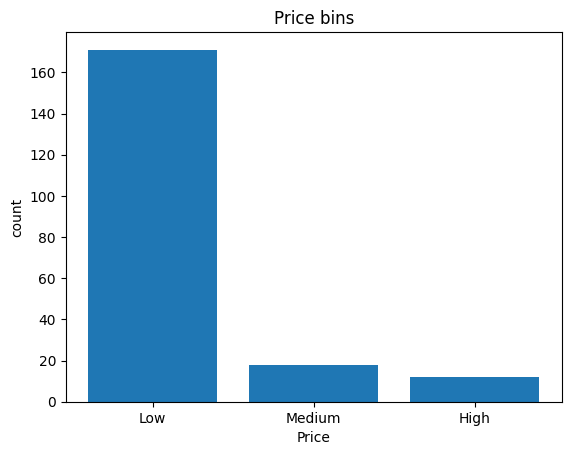

In [11]:
import pandas as pd
import matplotlib.pylab as plt
# equals: from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

bins = np.linspace(min(df["price"]), max(df["price"]), 4)
group_names = ['Low', 'Medium', 'High']
df['Price-binned'] = pd.cut(df['price'], bins, labels=group_names, include_lowest=True )

plt.bar(group_names, df["Price-binned"].value_counts())
plt.xlabel("Price")
plt.ylabel("count")
plt.title("Price bins")

##### Add bool values for column content 'fuel-type'

In [12]:
dummy_variable_1 = pd.get_dummies(df["fuel-type"])

# change column names for clarity
dummy_variable_1.rename(columns={'gas':'fuel-type-gas', 'diesel':'fuel-type-diesel'}, inplace=True)

# merge data frame "df" and "dummy_variable_1"
df = pd.concat([df, dummy_variable_1], axis=1)

# drop original column "fuel-type" from "df"
df.drop("fuel-type", axis = 1, inplace=True)

##### Find the correlation between the following columns: bore, stroke, compression-ratio, and horsepower.

In [13]:
df[['bore', 'stroke', 'compression-ratio', 'horsepower']].corr()

,bore,stroke,compression-ratio,horsepower
bore,1.000000,-0.055390,0.001250,0.568527
stroke,-0.055390,1.000000,0.187923,0.100040
compression-ratio,0.001250,0.187923,1.000000,-0.214576
horsepower,0.568527,0.100040,-0.214576,1.000000


##### Plot engine size as potential predictor variable of price

(0.0, 53075.1867401442)

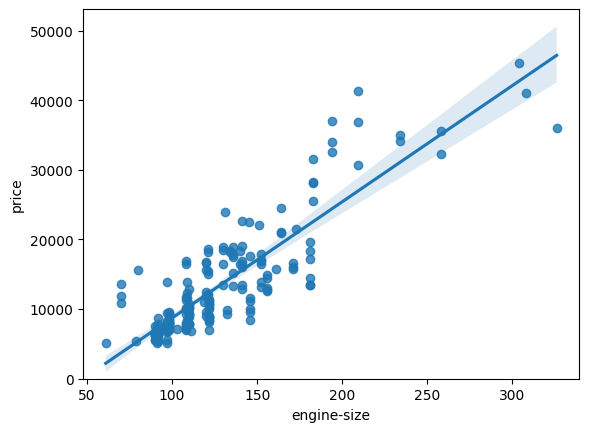

In [ ]:
# "regplot" plots the scatterplot plus the fitted regression line 
# for the data
sns.regplot(x="engine-size", y="price", data=df)
plt.ylim(0,)

 We can examine the correlation between 'engine-size' and 'price' and see that it's approximately 0.87.


In [15]:
df[["engine-size", "price"]].corr()

,engine-size,price
engine-size,1.000000,0.872335
price,0.872335,1.000000


##### Categorical variables

These are variables that describe a 'characteristic' of a data unit, and are selected from a small group of categories. The categorical variables can have the type "object" or "int64". A good way to visualize categorical variables is by using boxplots.

<Axes: xlabel='body-style', ylabel='price'>

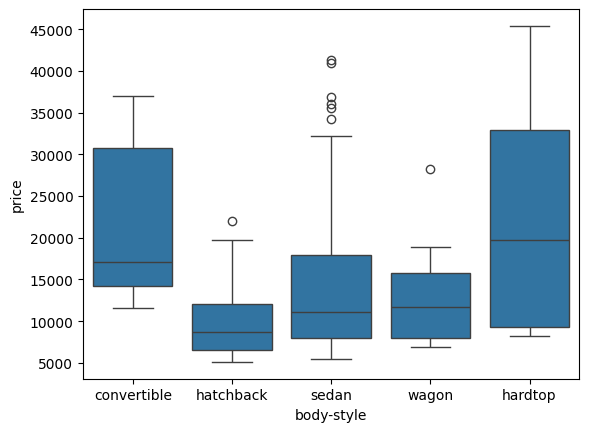

In [16]:
sns.boxplot(x="body-style", y="price", data=df)

We see that the distributions of price between the different body-style categories have a significant overlap, so body-style would not be a good predictor of price.

<Axes: xlabel='engine-location', ylabel='price'>

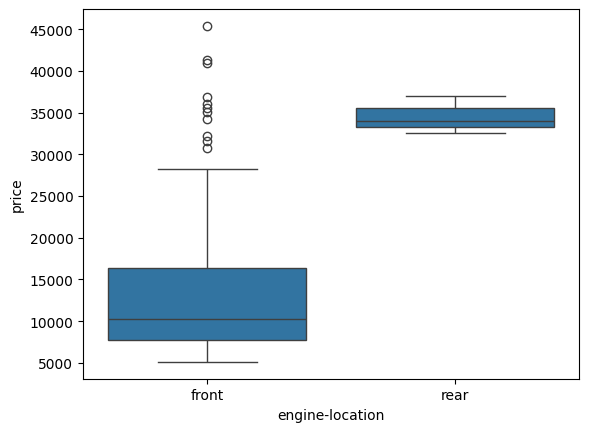

In [17]:
sns.boxplot(x="engine-location", y="price", data=df)

Here we see that the distribution of price between these two engine-location categories, front and rear, are distinct enough to take engine-location as a potential good predictor of price.

##### Descriptive Statistical Analysis

The describe function automatically computes basic statistics for all continuous variables. Any NaN values are automatically skipped in these statistics.

In [ ]:
# The default setting of "describe" skips variables of type object.
# We can apply the method "describe" on the variables of type 'object' 
# as follows:

df.describe(include=['object'])

,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,horsepower,peak-rpm
count,201,201,201,201,201,201,201,201,201,199,199
unique,22,2,2,5,3,2,6,7,8,58,22
top,toyota,std,four,sedan,fwd,front,ohc,four,mpfi,68,5500
freq,32,165,115,94,118,198,145,157,92,19,36


Value counts is a good way of understanding how many units of each characteristic/variable we have. We can apply the "value_counts" method on the column "drive-wheels". Don’t forget the method "value_counts" only works on pandas series, not pandas dataframes. As a result, we only include one bracket <code>df['drive-wheels']</code>, not two brackets <code>df[['drive-wheels']]</code>.

In [23]:
df['drive-wheels'].value_counts()

# We can convert the series to a dataframe as follows:
drive_wheels_counts = df['drive-wheels'].value_counts().to_frame()
# Change the column header
drive_wheels_counts.rename(columns={'drive-wheels': 'value_counts'}, inplace=True)
# Change the index header
drive_wheels_counts.index.name = 'drive-wheels'
drive_wheels_counts

,count
drive-wheels,
fwd,118
rwd,75
4wd,8


We can do the same process for the variable 'engine-location'.


In [24]:
# engine-location as variable
engine_loc_counts = df['engine-location'].value_counts().to_frame()
engine_loc_counts.rename(columns={'engine-location': 'value_counts'}, inplace=True)
engine_loc_counts.index.name = 'engine-location'
engine_loc_counts.head(10)

,count
engine-location,
front,198
rear,3


After examining the value counts of the engine location, we see that engine location would not be a good predictor variable for the price. This is because we only have three cars with a rear engine and 198 with an engine in the front, so this result is skewed. Thus, we are not able to draw any conclusions about the engine location.

##### Basics of grouping

In [25]:
# Let's group by the variable "drive-wheels". 
# We see that there are 3 different categories of drive wheels.
print(df['drive-wheels'].unique())

['rwd' 'fwd' '4wd']


In [29]:
# If we want to know, on average, which type of drive wheel is most valuable, we can group "drive-wheels" and then average them.
# We can select the columns 'drive-wheels', 'body-style' and 'price', 
# then assign it to the variable "df_group_one".
df_gptest = df[['drive-wheels','body-style','price']]
grouped_test1 = df_gptest.groupby(['drive-wheels','body-style'],as_index=False).mean()
grouped_test1

,drive-wheels,body-style,price
0,4wd,hatchback,7603.000000
1,4wd,sedan,12647.333333
2,4wd,wagon,9095.750000
3,fwd,convertible,11595.000000
4,fwd,hardtop,8249.000000
5,fwd,hatchback,8396.387755
6,fwd,sedan,9811.800000
7,fwd,wagon,9997.333333
8,rwd,convertible,23949.600000
9,rwd,hardtop,24202.714286


This grouped data is much easier to visualize when it is made into a pivot table. A pivot table is like an Excel spreadsheet, with one variable along the column and another along the row. We can convert the dataframe to a pivot table using the method "pivot" to create a pivot table from the groups.

In [30]:
grouped_pivot = grouped_test1.pivot(index='drive-wheels',columns='body-style')
grouped_pivot

price                                            \
body-style   convertible       hardtop     hatchback         sedan   
drive-wheels                                                         
4wd                  NaN           NaN   7603.000000  12647.333333   
fwd              11595.0   8249.000000   8396.387755   9811.800000   
rwd              23949.6  24202.714286  14337.777778  21711.833333   

                            
body-style           wagon  
drive-wheels                
4wd            9095.750000  
fwd            9997.333333  
rwd           16994.222222

In [31]:
grouped_pivot = grouped_pivot.fillna(0) #fill missing values with 0
grouped_pivot

price                                            \
body-style   convertible       hardtop     hatchback         sedan   
drive-wheels                                                         
4wd                  0.0      0.000000   7603.000000  12647.333333   
fwd              11595.0   8249.000000   8396.387755   9811.800000   
rwd              23949.6  24202.714286  14337.777778  21711.833333   

                            
body-style           wagon  
drive-wheels                
4wd            9095.750000  
fwd            9997.333333  
rwd           16994.222222

##### Heatmap

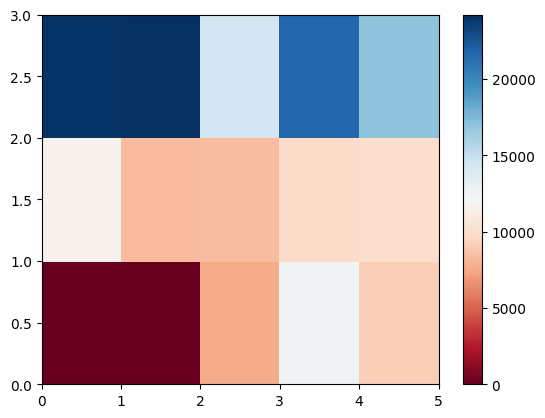

In [32]:
#use the grouped results
plt.pcolor(grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

The default labels convey no useful information to us. Let's change that:

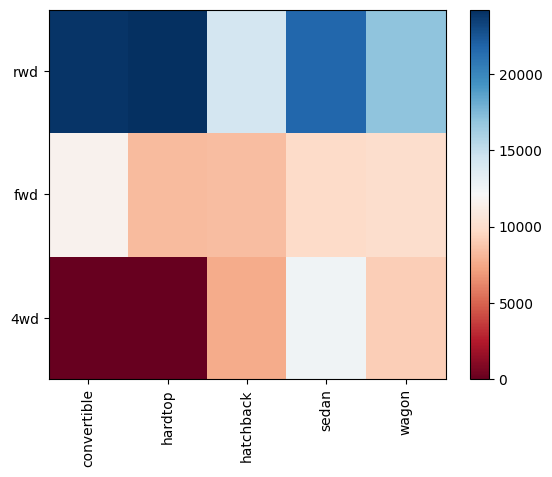

In [33]:
fig, ax = plt.subplots()
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

##### Correlation and Causation

Pearson Correlation is the default method of the function "corr". Like before, we can calculate the Pearson Correlation of the of the 'int64' or 'float64'  variables.

In [37]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 
# 'wheel-base' and 'price'. 
pearson_coef, p_value = stats.pearsonr(df['wheel-base'], df['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.584641822265508  with a P-value of P = 8.076488270732947e-20


Since the p-value is $<$ 0.001, the correlation between wheel-base and price is statistically significant, although the linear relationship isn't extremely strong (~0.585).